# Fake news detection

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [5]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [6]:
fake.shape

(23481, 4)

In [7]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [8]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [9]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [10]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [11]:
# Check the data
data.head()

,title,text,subject,date,target
0,Obama says U.S. funding to fight Zika is rapid...,WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,"August 4, 2016",true
1,"KID ROCK GOES OFF On Colin Kaepernick, Obamaca...",Kid Rock hasn t officially announced his run f...,left-news,"Sep 14, 2017",fake
2,Trump backs away from bipartisan Senate health...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"October 18, 2017",true
3,"U.S. may take movie, music roles in Malaysia f...",NEW YORK (Reuters) - The U.S. government may b...,politicsNews,"July 21, 2016",true
4,"At U.S.-China summit, Trump presses Xi on trad...","PALM BEACH, Fla. (Reuters) - President Donald ...",politicsNews,"April 7, 2017",true


In [12]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Obama says U.S. funding to fight Zika is rapid...,WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,true
1,"KID ROCK GOES OFF On Colin Kaepernick, Obamaca...",Kid Rock hasn t officially announced his run f...,left-news,fake
2,Trump backs away from bipartisan Senate health...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,true
3,"U.S. may take movie, music roles in Malaysia f...",NEW YORK (Reuters) - The U.S. government may b...,politicsNews,true
4,"At U.S.-China summit, Trump presses Xi on trad...","PALM BEACH, Fla. (Reuters) - President Donald ...",politicsNews,true


In [13]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,true
1,Kid Rock hasn t officially announced his run f...,left-news,fake
2,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,true
3,NEW YORK (Reuters) - The U.S. government may b...,politicsNews,true
4,"PALM BEACH, Fla. (Reuters) - President Donald ...",politicsNews,true


In [14]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,washington (reuters) - president barack obama ...,politicsNews,true
1,kid rock hasn t officially announced his run f...,left-news,fake
2,washington (reuters) - u.s. president donald t...,politicsNews,true
3,new york (reuters) - the u.s. government may b...,politicsNews,true
4,"palm beach, fla. (reuters) - president donald ...",politicsNews,true


In [15]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [16]:
# Check
data.head()

,text,subject,target
0,washington reuters president barack obama on ...,politicsNews,true
1,kid rock hasn t officially announced his run f...,left-news,fake
2,washington reuters us president donald trump ...,politicsNews,true
3,new york reuters the us government may become...,politicsNews,true
4,palm beach fla reuters president donald trump...,politicsNews,true


In [17]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to C:\Users\ADITI
[nltk_data]     ANIL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
data.head()

,text,subject,target
0,washington reuters president barack obama thur...,politicsNews,true
1,kid rock officially announced run us senate ev...,left-news,fake
2,washington reuters us president donald trump w...,politicsNews,true
3,new york reuters us government may become movi...,politicsNews,true
4,palm beach fla reuters president donald trump ...,politicsNews,true


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


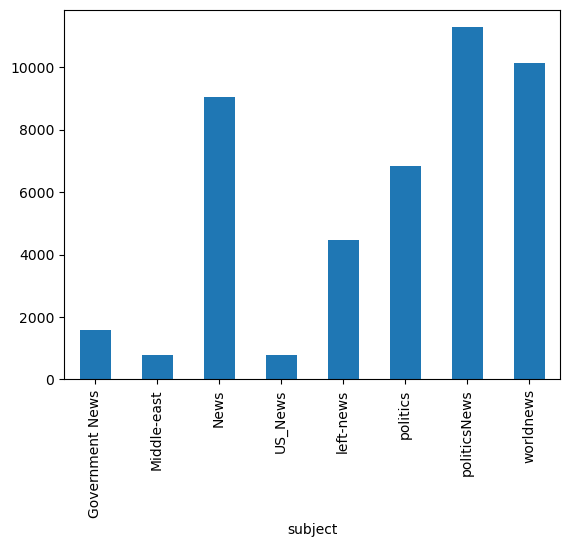

In [19]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


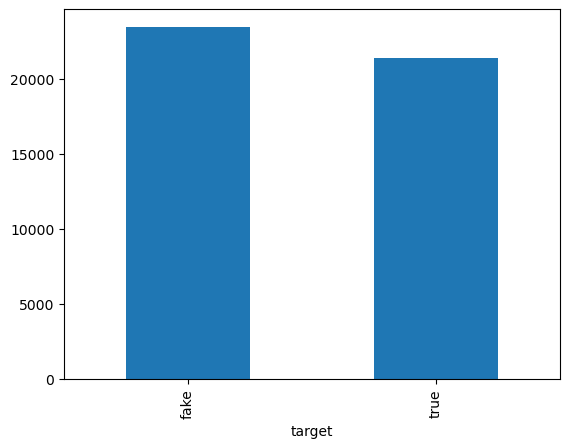

In [20]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [21]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

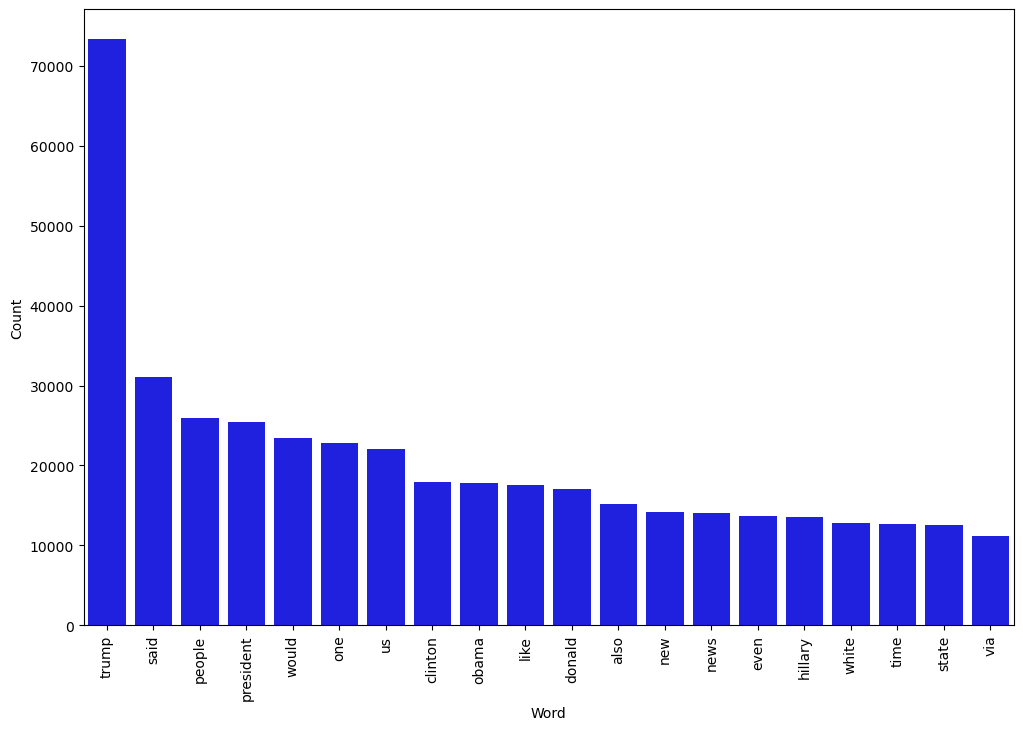

In [22]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

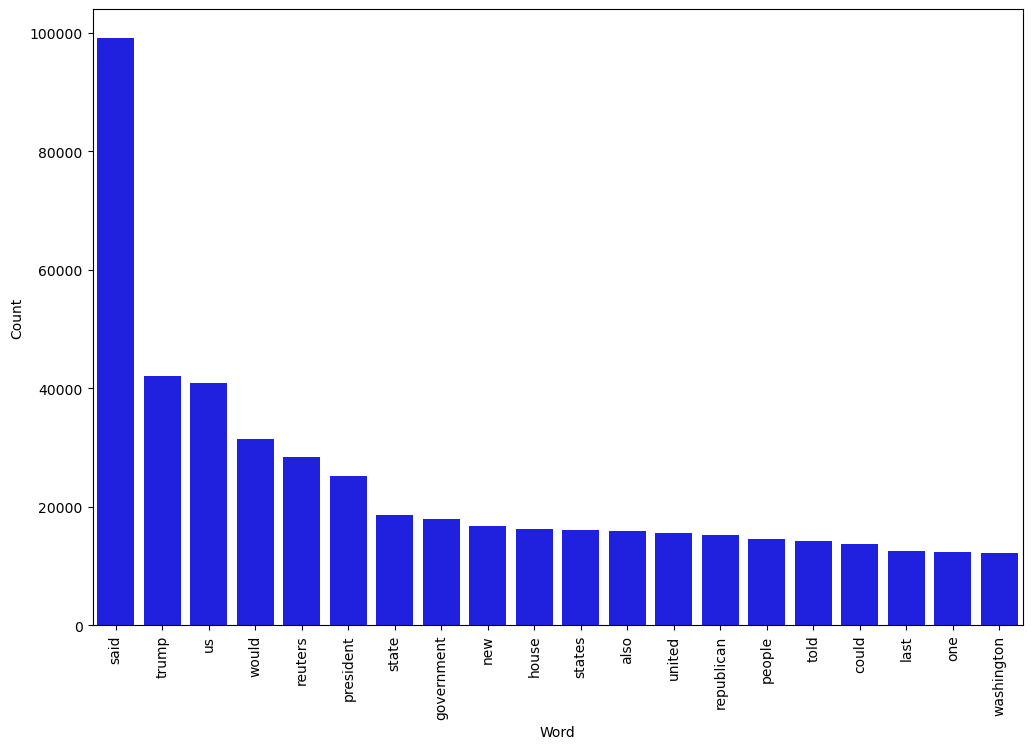

In [23]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [24]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [25]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Logistic regression

In [26]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.04%


Confusion matrix, without normalization


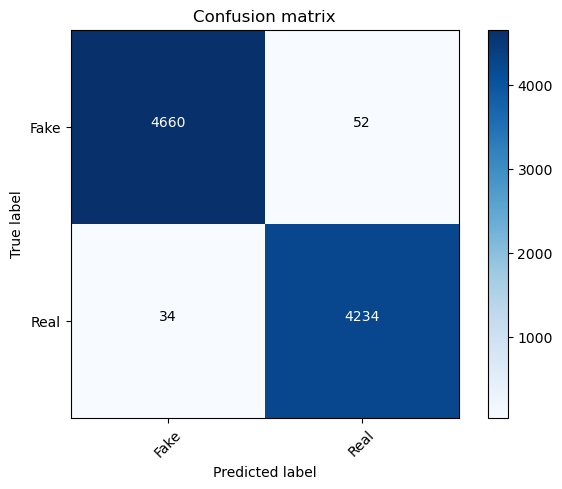

In [27]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Decision Tree Classifier

In [28]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20,
                                           splitter='best',
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.73%


Confusion matrix, without normalization


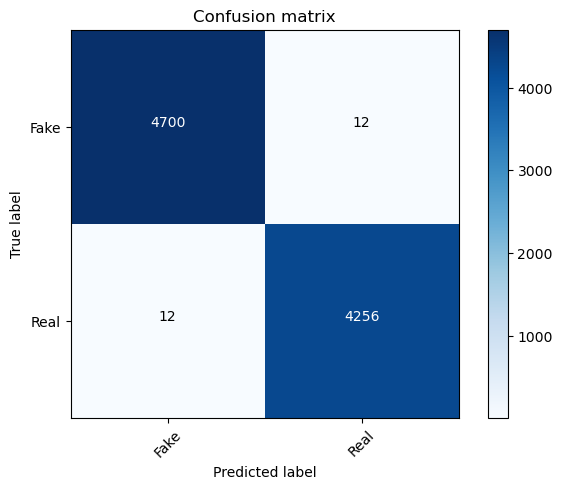

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.11%


Confusion matrix, without normalization


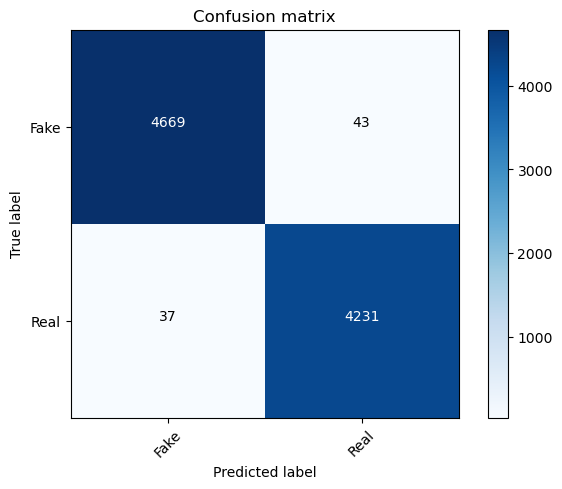

In [31]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn import svm


### SVM

In [33]:
# Define SVM pipeline
svm_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', svm.SVC(kernel='linear', C=1.0))
])

# Train SVM
svm_model = svm_pipe.fit(X_train, y_train)

# Make predictions on test data
svm_prediction = svm_model.predict(X_test)

# Evaluate model performance
print("\nSupport Vector Classifier:")
print("Testing Accuracy: {}".format(accuracy_score(y_test, svm_prediction)))
print("Testing F1 score: {}".format(f1_score(y_test, svm_prediction, average='weighted')))



Support Vector Classifier:
Testing Accuracy: 0.9965478841870824
Testing F1 score: 0.9965480521775861


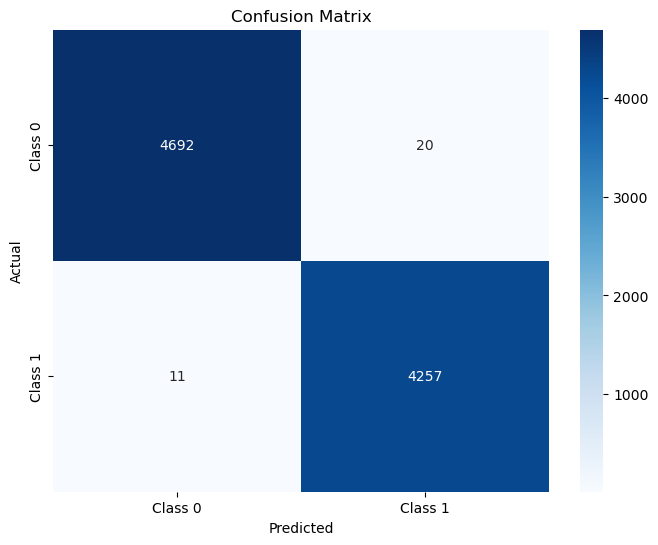

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Now you can use plot_confusion_matrix function
plot_confusion_matrix(y_test, svm_prediction, classes=['Class 0', 'Class 1'])
